In [28]:
!pip install vaderSentiment

    100% |████████████████████████████████| 133kB 4.7MB/s ta 0:00:01


In [31]:
from pprint import pprint
import datetime
import time
import requests

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

import tweepy                           

from twitter_config import (ApiKey,
                            ApiSecret,
                            AccessToken,
                            AccessTokenSecret)


from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [12]:
#Tweepy API Authentication
auth = tweepy.OAuthHandler(ApiKey, ApiSecret)
auth.set_access_token(AccessToken, AccessTokenSecret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [56]:
old_requests = []
old_urls = []
old_tweets = set()

# checks for mentions

def check_mentions():
    
    #Locally generated mentions data to be passed onto other functions
    global new_requests
    
    #empty list for not-previously-analyzed mentions
    new_requests = []


    mentions = api.mentions_timeline()
        
    for mention in mentions:
    
        # if tweet already analyzed, pass
        if mention['id'] in old_tweets:
            pass

        else:
            # add to old_tweets to avoid subsequent duplication
            old_tweets.add(mention['id'])
            
            #returns a list of all users mentioned in the tweet
            user_mentions = mention['entities']['user_mentions']
        
            for user in user_mentions:
            
                # If mentioned user is the bot itself, ignore
                if user['screen_name'] == '5000Awesomeo':
                    pass
                
                else:
                    # If mentioned user has already analyzed, 
                    # tweet apology to requesting user
                    if user['screen_name'] in old_requests:

                        dm_user = mention['user']['screen_name']
                        old_user = user['screen_name']
                        
                        # Check generate_tweets() for why this is commented. 
                        # Basically breaks because it tries to index an empty list 
                        # that logically should be populated but isn't because of delays
                        # in either an API call response or generating graphical elements.
                                                
                        #old_url = old_urls[old_requests.index(old_analyzed_user)]
                        
                        # api.update_status(f'Sorry @{dm_user}, @{old_user} has already been analyzed.') 
                        
                        #You can see the tweet here: {old_url}')
                    
                    # If mentioned user is new, add to previously analyzed users
                    # Also add a dict requested analysis, requesting user, and status id of request
                    else:
                        old_requests.append(user['screen_name'])
                        #Used an insert() below instead of append() so oldest newly detected tweet goes first
                        new_requests.insert(0, {'Analysis requested': user['screen_name'],
                                                  'User requesting': mention['user']['screen_name'],
                                                  'Request Status ID' : mention['id']
                                                 })

In [22]:
# This function pulls 500 tweets from target_user and does the sentiment analysis

def sentiment_analysis(target_user):
    
    #global sentiment_list built to pass to other functions
    global sentiment_list
    
    target_user = target_user
    
    sentiment_list = []
    
    #This acts as a counter for the '# of tweets ago'. starts at 0, ends at -500
    tweets_ago = 1
    
    for page in range(5):

        public_tweets = api.user_timeline(target_user, page=page, count=100)
    
        for tweet in public_tweets:
        
            text = tweet['text']
        
            score = analyzer.polarity_scores(text)
            
            tweets_ago -=1
        
            sentiment_list.append({'Compound Score': score['compound'],
                                'Tweets Ago': tweets_ago})
    return sentiment_list

In [23]:
# This function pulls 500 tweets from target_user and does the sentiment analysis

def sentiment_analysis(target_user):
    
    #global sentiment_list built to pass to other functions
    global sentiment_list
    
    target_user = target_user
    
    sentiment_list = []
    
    #This acts as a counter for the '# of tweets ago'. starts at 0, ends at -500
    tweets_ago = 1
    
    for page in range(5):

        public_tweets = api.user_timeline(target_user, page=page, count=100)
    
        for tweet in public_tweets:
        
            text = tweet['text']
        
            score = analyzer.polarity_scores(text)
            
            tweets_ago -=1
        
            sentiment_list.append({'Compound Score': score['compound'],
                                'Tweets Ago': tweets_ago})

In [24]:
#takeing the sentiment scores from sentiment_analysis and generating the sentiment plot

def generate_plot(target_user):

    sentiment_df = pd.DataFrame(sentiment_list)

    # figure out the date to put on plots
    date = datetime.date.today().strftime("%B %d, %Y")  
    
    plot = sentiment_df.plot('Tweets Ago', 
                             'Compound Score',
                             marker='o',
                             markerfacecolor='white',
                             markeredgecolor='blue',
                             linewidth=1,
                             figsize=(12,9),
                             kind='line',
                             fontsize=15,
                             antialiased = True)
    
    plot.set_title(f'''Sentiment Analysis of @{target_user}\n(Generated {date})''', 
                   fontsize=20)
    
    plot.set_xlabel('Tweets Ago', 
                    fontsize=15)
    
    plot.set_ylabel('Tweet Polarity', 
                    fontsize=15)
    
    plot.set_ylim([-1, 1])
    
    plot.grid(True)
        
    plot.legend().set_visible(False)
    
    fig = plot.get_figure()
    
    fig.savefig('output.png')
    return plt.show()

In [25]:
#Makes the API call, calling sentiment_analysis() and generate_plot()

def generate_tweets():

    for request in new_requests:
    
        requested_subject = request['Analysis requested']
        
        user_requesting = request['User requesting']
        
#        Tweepy has a field 'status id of tweet replying to'
        request_status_id = str(request['Request Status ID'])
        
        sentiment_analysis(requested_subject)
        
        generate_plot(requested_subject)
                
        tweet_text = f'''Sentiment analysis of @{requested_subject}'s previous 500 tweet (requested by @{user_requesting})'''
        
        api.update_with_media('output.png', tweet_text, request_status_id)
        
        
        last_tweet = api.user_timeline('@5000Awesomeo', count=1)
        last_tweet_url = last_tweet[0]['entities']['media'][0]['display_url']
        old_urls.append('https://' + last_tweet_url)

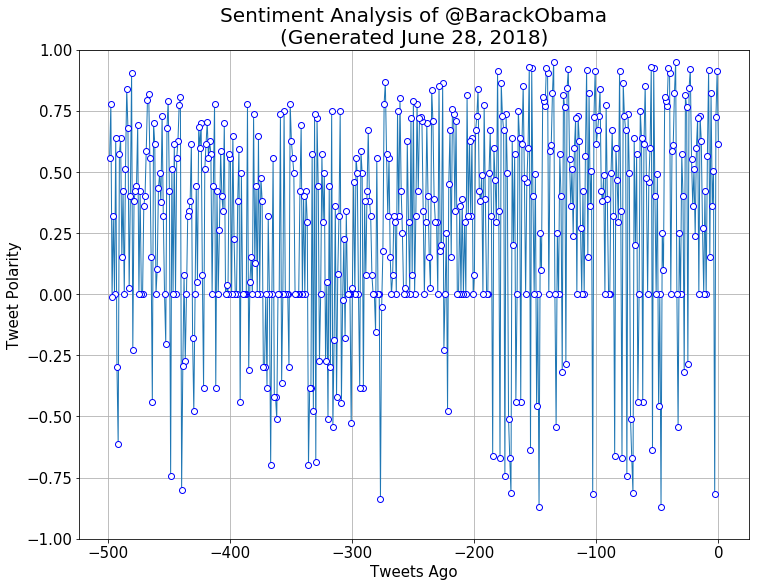

In [35]:
#Testing functions

sentiment_analysis('BarackObama')
generate_plot('BarackObama')


In [57]:
check_mentions()

#it keeps getting me this Error
#TweepError: [{'code': 187, 'message': 'Status is a duplicate.'}]
#i couldn't solve it


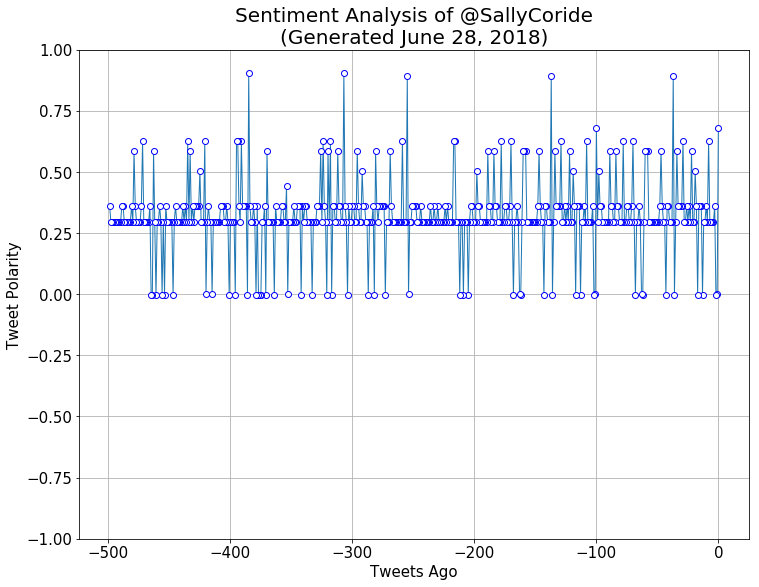

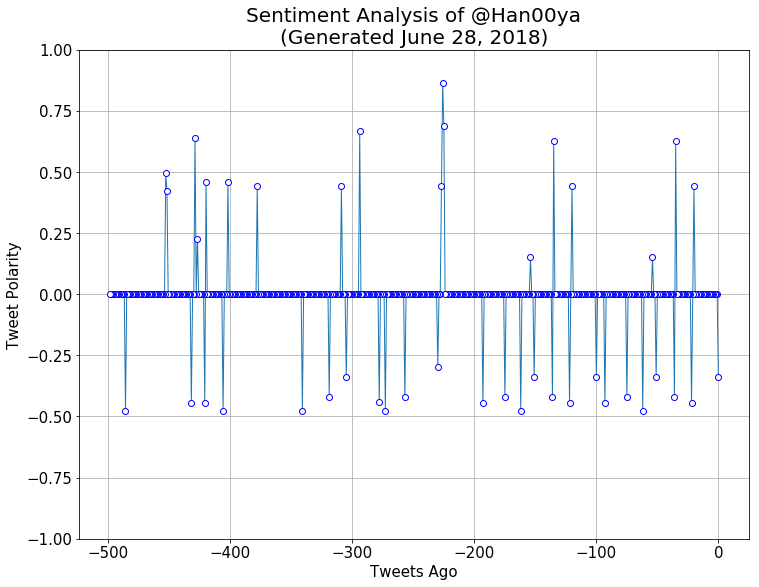

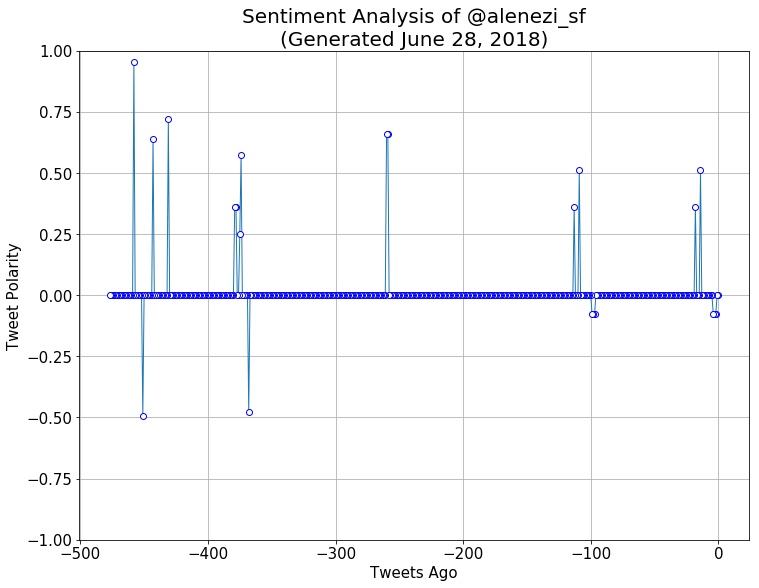

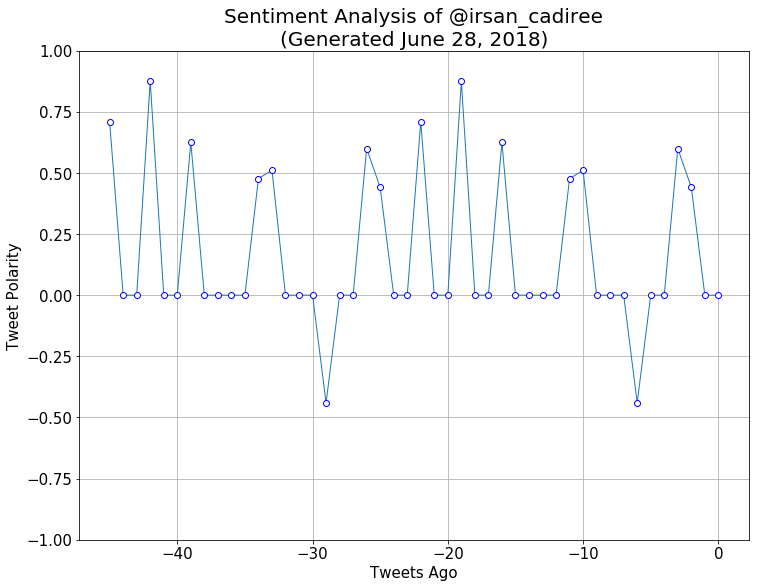

In [58]:
generate_tweets()
